# Prize-Collecting Steiner Tree (PCSTP)

## Libs Importing

In [1]:
import sys
import os
import time
import networkx as nx

sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
from pcstp.instances.generator import generate_random_steiner
from pcstp.utils.draw import draw_steiner_graph

## Experiments

In [3]:
SEED = 100

In [4]:
G, (nodes, edges, position_matrix, edges_cost, terminals, prizes) = generate_random_steiner(
    num_nodes=25,
    num_edges=20,
    max_node_degree=10,
    min_prize=1,
    max_prize=100,
    num_terminals=5,
    min_edge_cost=0,
    max_edge_cost=10,
    cost_as_length=False,
    max_iter=100,
    seed=SEED
)

terminals:  (5,)
prizes:  (5,)


In [5]:
from pcstp.steinertree import SteinerTreeProblem
from pcstp.instances.reader import SteinlibReader, DatReader
from pcstp.solver.base import computes_steiner_cost

The instance can be imported from a file or generated through the instance generator presented above.

In [6]:
stp = SteinerTreeProblem(graph=G, terminals=terminals)

In [7]:
from pcstp.solver.base import computes_steiner_cost

In [8]:
from pcstp.utils.graph import preprocessing

In [9]:
filename = '../data/instances/benchmark/PCSPG-CRR/C01-A.stp'

if filename.endswith('.stp'):
    stp_reader = SteinlibReader()
else:
    stp_reader = DatReader()

# stp = stp_reader.parser(filename=filename)


In [10]:
print("Nodes: ", len(stp.graph.nodes))
print("Edges: ", len(stp.graph.edges))
print("Terminals: ", stp.terminals)

Nodes:  25
Edges:  24
Terminals:  [13  0 19 17  8]


In [11]:
G, terminals = preprocessing(stp.graph, stp.terminals, verbose=True)

Iteration: 1 - Removing nodes: [1, 2, 5, 6, 11, 15, 16, 22, 24]
Iteration: 2 - Removing nodes: [14, 20]
Iteration: 3 - Removing nodes: [9, 23]
Iteration: 4 - Removing nodes: [12]


In [12]:
stp_preprocessed = SteinerTreeProblem(graph=G, terminals=terminals)

In [ ]:
print("Nodes: ", len(stp_preprocessed.graph.nodes))
print("Edges: ", len(stp_preprocessed.graph.edges))
print("Terminals: ", stp_preprocessed.terminals)

In [ ]:
import networkx.algorithms.components as comp
conn_components = list(comp.connected_components(stp_preprocessed.graph))

print(conn_components)

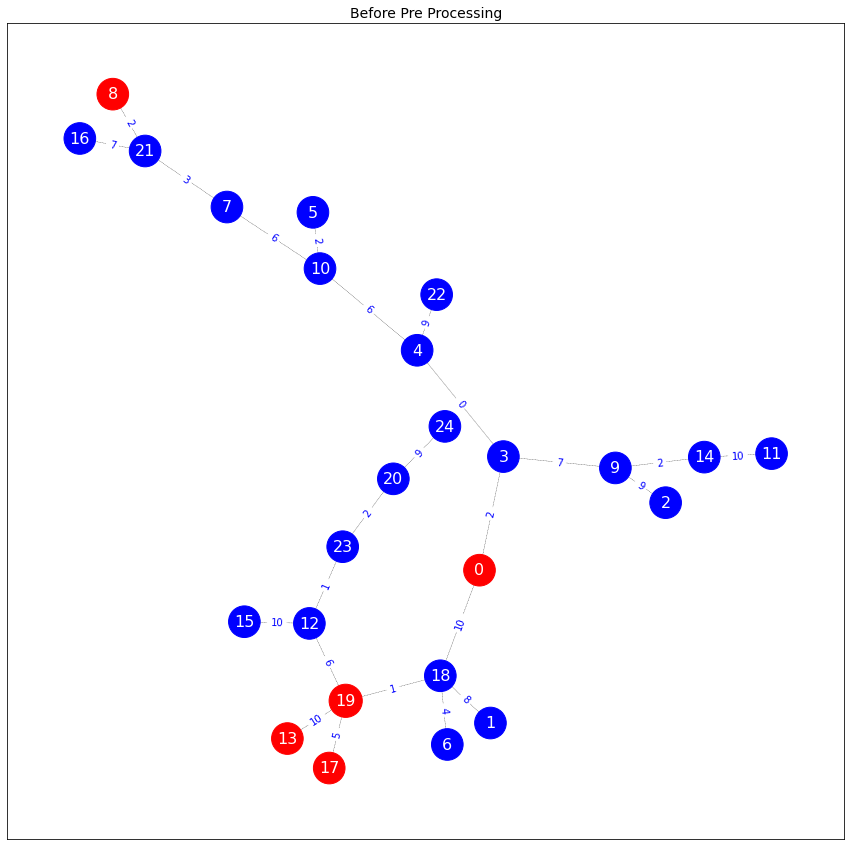

In [17]:
try:
    draw_steiner_graph(
        stp.graph,
        plot_title=f'Before Pre Processing',
        node_label='name',
        seed=SEED
    )
except Exception as e:
    print(e)


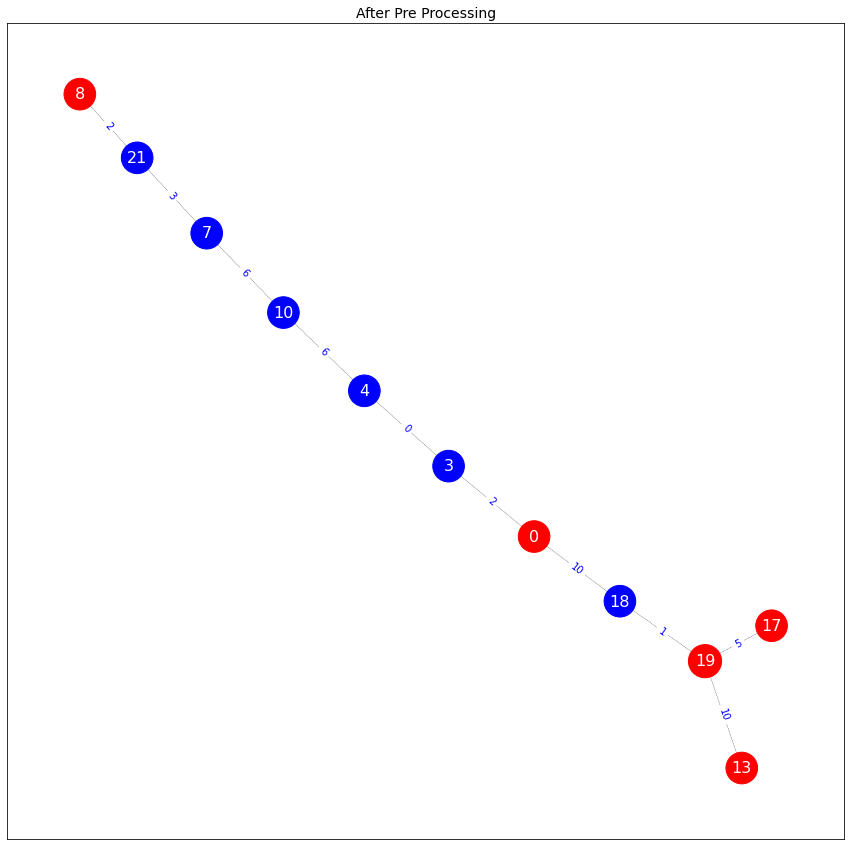

In [19]:
try:
    draw_steiner_graph(
        stp_preprocessed.graph,
        plot_title=f'After Pre Processing',
        node_label='name',
        seed=SEED
    )
except Exception as e:
    print(e)


## Solution obtained with NetworkX Steiner Tree Approximation Algorithm

In [14]:
# %%timeit -n 100

start_time = time.time()

nx_steiner_tree = nx.algorithms.approximation.steiner_tree(
    stp_preprocessed.graph,
    stp_preprocessed.terminals,
    weight='cost'
)

networkx_duration = time.time() - start_time
networkx_cost = computes_steiner_cost(stp.graph, nx_steiner_tree, stp.terminals)
print(f'Cost: {networkx_cost}')


Cost: 45.0


In [ ]:
tree = stp.graph.subgraph(nx_steiner_tree.nodes)

In [ ]:
print(f'Duration: {networkx_duration*1000} ms')

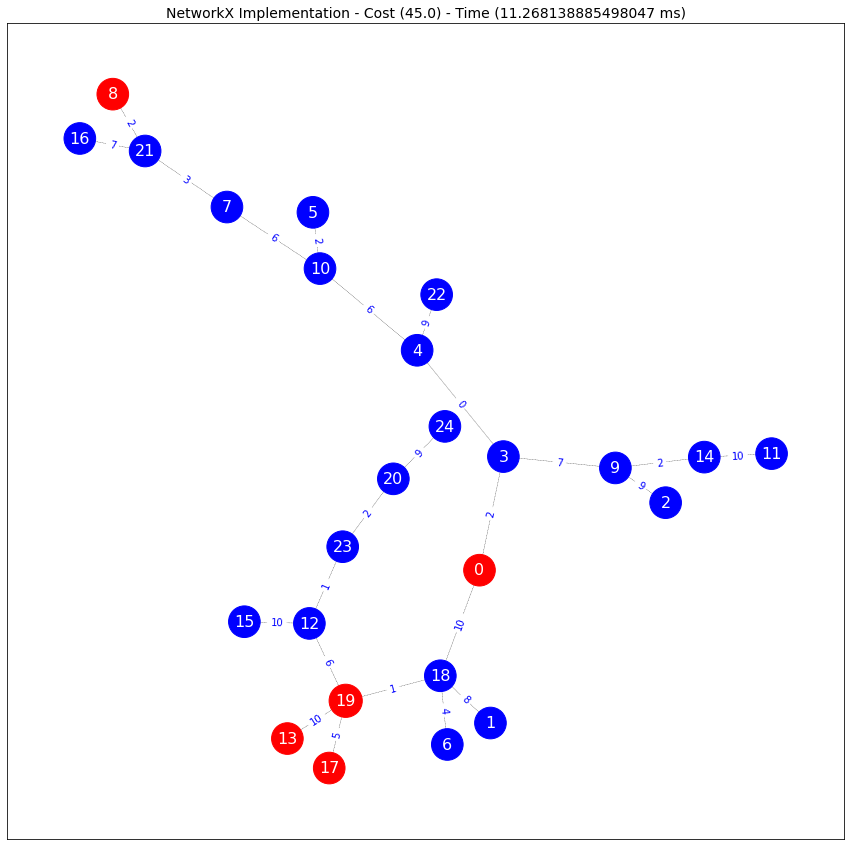

In [16]:
try:
    draw_steiner_graph(
        stp_preprocessed.graph,
        steiner_graph=nx_steiner_tree,
        plot_title=f'NetworkX Implementation - Cost ({networkx_cost}) - Time ({networkx_duration * 1000} ms)',
        node_label='name',
        seed=SEED
    )
except Exception as e:
    print(e)


## Solution obtained with Ant Colony Optimization

In [ ]:
from pcstp.solver.aco import AntColony

In [ ]:
solver = AntColony(
    graph=stp_preprocessed.graph,
    terminals=stp.terminals,
    iterations=1,
    num_ants=1,
    evaporation_rate=0.2,
    alpha=1.0,
    beta=3.0,
    # beta_evaporation_rate=0.2,
    initial_pheromone=1,
    pheromone_amount=10,
    pheromone_deposit_strategy='traditional',
    pheromone_initialization_strategy='same_value',
    choose_best=0.1,
    log_level='debug',
    early_stopping=None,
    normalize_distance_prize=False,
    allow_edge_perturbation=False,
    seed=SEED
)
steiner_tree, steirner_cost = solver.solve()


In [ ]:
print(f'Cost: {steirner_cost}')

In [ ]:
print(f'Duration: {solver._duration * 1000} ms')

In [ ]:
solver.best_route

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
if len(solver.history) > 1:
    fig, ax = plt.subplots(1, 1,figsize=(5,5))

    ax.plot(solver.history)
    ax.set_title("ACO Steiner Cost per Iterations")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Steiner Cost")

In [ ]:
try:
    draw_steiner_graph(
        stp_preprocessed.graph,
        steiner_graph=steiner_tree,
        plot_title=f'ACO Implementation - Cost ({networkx_cost}) - Time ({networkx_duration * 1000} ms)',
        node_label='name'
    )
except:
    pass

print('Best Route to find all terminals:', solver.best_route)

